<a href="https://www.kaggle.com/code/laraibakhtar/ai-sarwar-praject?scriptVersionId=178150244" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
import keras
from keras.layers import Dense,Input, InputLayer, Flatten
from keras.models import Sequential, Model, load_model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix,f1_score


2024-05-17 07:20:10.875948: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 07:20:10.876048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 07:20:11.022556: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install kaggle

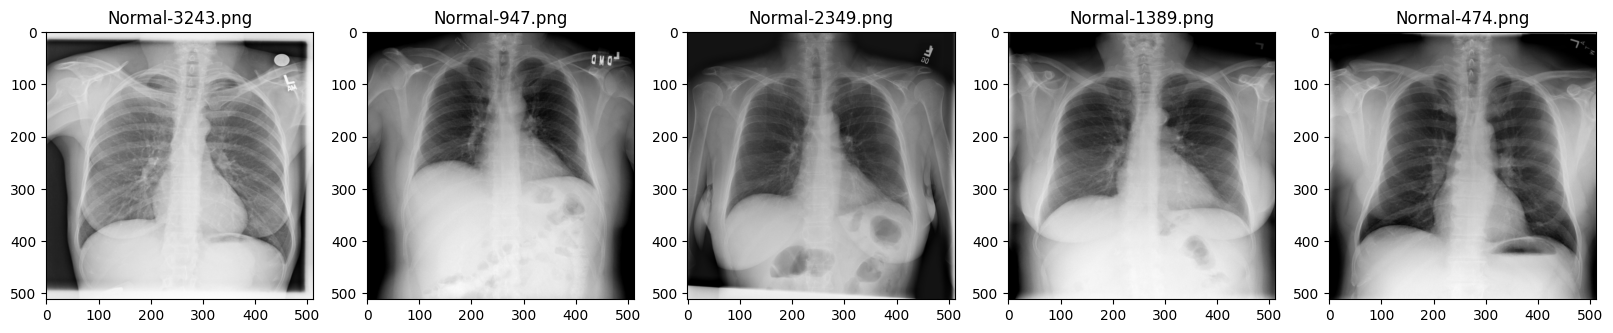

In [3]:
#View some samples of the dataset
import random
plt.figure(figsize=(20,20))
folder=r'/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal'
for i in range(5):
    file = random.choice(os.listdir(folder))
    image_path= os.path.join(folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)


In [4]:
def load_and_preprocess_data(data_dir, image_size):
    images = []
    labels = []

    # Iterate through each folder (each class of flowers)
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)

        # Iterate through each image in the class folder
        # Check if it's a directory
        if not os.path.isdir(class_dir):
            continue  # Skip if it's not a directory
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)

            # Read image and resize
            image = cv2.imread(image_path) #reads in BGR format
            #To read an image in grayscale 
            image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            image = cv2.resize(image, image_size)

            # Normalize pixel values to [0, 1]
            image = image.astype('float32') / 255.0

            # Append to the lists
            images.append(image)
            labels.append(class_name)

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels



In [5]:
dataset_dir = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database"

In [6]:
image_size = (128, 128)

images, labels = load_and_preprocess_data(dataset_dir, image_size)

In [7]:
images

array([[[0.        , 0.        , 0.        , ..., 0.05490196,
         0.02352941, 0.        ],
        [0.        , 0.        , 0.00784314, ..., 0.05490196,
         0.02352941, 0.        ],
        [0.        , 0.        , 0.00784314, ..., 0.05098039,
         0.01960784, 0.        ],
        ...,
        [0.        , 0.        , 0.01960784, ..., 0.15294118,
         0.11372549, 0.        ],
        [0.        , 0.        , 0.        , ..., 0.00392157,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.03529412, 0.00784314, 0.00392157, ..., 0.2509804 ,
         0.24313726, 0.29411766],
        [0.03921569, 0.        , 0.        , ..., 0.2509804 ,
         0.24705882, 0.3019608 ],
        [0.05098039, 0.        , 0.        , ..., 0.2509804 ,
         0.24313726, 0.3019608 ],
        ...,
        [0.01176471, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.0

In [8]:
from sklearn.preprocessing import LabelEncoder
# Convert class labels to one-hot encoded vectors
label_encoder = LabelEncoder()
encoded_class_names = label_encoder.fit_transform(labels)

In [9]:
encoded_class_names

array([1, 1, 1, ..., 0, 0, 0])

In [10]:
labels

array(['Tuberculosis', 'Tuberculosis', 'Tuberculosis', ..., 'Normal',
       'Normal', 'Normal'], dtype='<U12')

In [11]:
from sklearn.model_selection import train_test_split


# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, encoded_class_names, test_size=0.33, random_state=42)

y_train = np.array(y_train)
y_test = np.array(y_test)
X_train = np.array(X_train)
X_test = np.array(X_test)

# Check the shapes of the datasets
print("Train images shape:", X_train.shape)
print("Train labels shape:", X_test.shape)
print("Validation images shape:", y_train.shape)
print("Validation labels shape:", y_test.shape)


Train images shape: (2814, 128, 128)
Train labels shape: (1386, 128, 128)
Validation images shape: (2814,)
Validation labels shape: (1386,)


In [12]:
y_train

array([0, 0, 1, ..., 0, 0, 0])

In [13]:
model = keras.Sequential([
    keras.layers.Conv2D(128, (3, 3), input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    keras.layers.LeakyReLU(alpha=0.02),
    
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(128, (3, 3)),
    keras.layers.LeakyReLU(alpha=0.02),
    
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.GlobalMaxPooling2D(),
    
    keras.layers.Dense(512),
    keras.layers.LeakyReLU(alpha=0.02),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(10),
    keras.layers.Activation('sigmoid')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()




/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 126, 126, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 61, 61, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,042 (859.54 KB)

 Trainable params: 220,042 (859.54 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Compile the model
initial_lr = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps=10000, decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50


2024-05-17 07:22:27.884436: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.28782, expected 2.7295
2024-05-17 07:22:27.884491: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.26404, expected 2.70572
2024-05-17 07:22:27.884500: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.97899, expected 2.42067
2024-05-17 07:22:27.884508: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.06421, expected 2.50589
2024-05-17 07:22:27.884515: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.86175, expected 2.30343
2024-05-17 07:22:27.884523: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.68058, expected 2.12226
2024-05-17 07:22:27.884530: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.63026, expected 2.07194
2024-05-17 07:22:27.884538: E external/local_xla/xla/ser

 6/71 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4537 - loss: 1.9269

I0000 00:00:1715930554.014500      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


69/71 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7716 - loss: 0.8324

2024-05-17 07:22:37.574101: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15876: 2.08155, expected 1.31982
2024-05-17 07:22:37.574167: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15877: 1.92845, expected 1.16672
2024-05-17 07:22:37.574178: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15878: 2.13399, expected 1.37226
2024-05-17 07:22:37.574188: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15879: 2.05756, expected 1.29583
2024-05-17 07:22:37.574197: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15880: 1.85552, expected 1.09379
2024-05-17 07:22:37.574205: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15881: 2.01452, expected 1.25279
2024-05-17 07:22:37.574214: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15882: 2.09391, expected 1.33218
2024-05-17 07:22:37.574224:

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7730 - loss: 0.8245

2024-05-17 07:22:42.311701: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 1.46115, expected 1.21331
2024-05-17 07:22:42.311777: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 1.42193, expected 1.17408
2024-05-17 07:22:42.311806: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 60: 1.47421, expected 1.22636
2024-05-17 07:22:42.311833: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 61: 1.31364, expected 1.06579
2024-05-17 07:22:42.311845: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 66: 0.916936, expected 0.669088
2024-05-17 07:22:42.311855: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 85: 1.47503, expected 1.22718
2024-05-17 07:22:42.311866: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 143: 1.31424, expected 1.0664
2024-05-17 07:22:42.311877: E external/local_x

71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.7737 - loss: 0.8207 - val_accuracy: 0.8419 - val_loss: 0.3851
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8521 - loss: 0.3189 - val_accuracy: 0.8650 - val_loss: 0.3583
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8489 - loss: 0.3043 - val_accuracy: 0.8988 - val_loss: 0.2504
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9038 - loss: 0.2131 - val_accuracy: 0.9147 - val_loss: 0.2088
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9333 - loss: 0.1743 - val_accuracy: 0.9591 - val_loss: 0.1481
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9474 - loss: 0.1503 - val_accuracy: 0.9574 - val_loss: 0.1468
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9471 - loss: 0.1287 - val_accuracy: 0.9396 - val_loss: 0.1540
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9420 - loss: 0.1390 - val_accuracy: 0.9609 - val_loss: 

In [16]:
predicted_labels = model.predict(X_test)
predicted_labels = np.argmax(predicted_labels, axis=1)
#predicted_class_names = label_encoder.inverse_transform(predicted_labels)

f1 = f1_score(y_test, predicted_labels, average='macro')
report = classification_report(y_test, predicted_labels)

print("F1 Score:", f1)
print("Classification Report:")
print(report)

37/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2024-05-17 07:24:07.037034: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.21579, expected 1.47542
2024-05-17 07:24:07.037092: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.92205, expected 2.18169
2024-05-17 07:24:07.037101: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.31911, expected 2.57874
2024-05-17 07:24:07.037109: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.23714, expected 1.49678
2024-05-17 07:24:07.037117: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.90822, expected 2.16785
2024-05-17 07:24:07.037124: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.66842, expected 1.92805
2024-05-17 07:24:07.037132: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 1.86069, expected 1.12033
2024-05-17 07:24:07.037139: E external/local_xla/xla/se

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
F1 Score: 0.960048391252888
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1146
           1       0.89      0.98      0.93       240

    accuracy                           0.98      1386
   macro avg       0.94      0.98      0.96      1386
weighted avg       0.98      0.98      0.98      1386

